In [6]:
import os
os.chdir('../')

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as tF
import numpy as np
import matplotlib.pyplot as plt

import functional as F

In [8]:
def label_to_membership(labels):
    n_class = labels.max() + 1
    n_samples = labels.shape[0]
    membership = torch.zeros(n_samples, n_class)
    for j in range(n_class):
        idx_j = labels == j
        membership[idx_j, j] = 1.
    return membership

## True MCR2 loss

In [9]:
def true_loss_discrimn(Z, eps):
    d, n = Z.shape
    I = torch.eye(d)
    return 0.5 * torch.logdet(I + d / (n * eps) * Z @ Z.T)

def true_loss_compress(Z, Pi, eps):
    d, n = Z.shape
    I = torch.eye(d).to(Z.device)
    compress_loss = 0.
    for j in range(Pi.shape[1]):
        trPi = Pi[:, j].sum()
        scalar = d / (trPi * eps)
        log_det = torch.logdet(I + scalar * Z @ Pi[:, j].diag() @ Z.T)
        compress_loss += trPi / (2 * n) * log_det
    return compress_loss

## Second Variational Form

In [10]:
def var_loss_discrimn(Z, eps):
    d, n = Z.shape
    I = torch.eye(d).to(Z.device)
    return 0.5 * torch.logdet(I + d / (n * eps) * Z @ Z.T)

def var_loss_compress(Z, Pi, A, eps):
    p, m = Z.shape
    _, k = Pi.shape
    I = torch.eye(p)
    compress_loss = 0.
    r = torch.nn.ReLU()
    ones = torch.ones(A.shape[1])
    for j in range(k):
        trPi = torch.sum(Pi[:,j])
        scalar = p / (trPi * eps)
        log_det = torch.sum(ones + scalar * r(A[j]))
        compress_loss += log_det * trPi / m
    return compress_loss / 2.

def var_reg_U(Z, Pi, A, U):
    _, k = Pi.shape
    matrix_loss = 0.
    U = torch.nn.functional.normalize(U, dim = 0)
    r = torch.nn.ReLU()
    for j in range(k):
        matrix_loss += torch.norm(Z@Pi[:,j].diag()@Z.T - U@torch.diag(r(A[j]))@U.T)**2
    return  matrix_loss / 2

In [46]:
class MCR2Variational(nn.Module):
    """Equation 10 in writeup. """
    def __init__(self, eps, mu):
        super(MCR2Variational, self).__init__()
        self.eps = eps
        self.mu = mu
        
    def loss_discrimn(self, Z):
        d, n = Z.shape
        I = torch.eye(d).to(Z.device)
        return 0.5 * torch.logdet(I + d / (n * self.eps) * Z @ Z.T)

    def loss_compress(self, Z, Pi, A):
        d, m = Z.shape
        _, k= Pi.shape
        I = torch.eye(d).to(Z.device)
        compress_loss = 0.
        r = torch.nn.ReLU()
        ones = torch.ones(A.shape[1])
        for j in range(k):
            trPi = torch.sum(Pi[:,j])
            scalar = d / (trPi * eps)
            log_det = torch.sum(torch.log(ones + scalar * r(A[j])))
            compress_loss += log_det * trPi / m
        return compress_loss / 2

    def reg_UA(self, Z, Pi, A, U):
        _, k = Pi.shape
        matrix_loss = 0.
        U = torch.nn.functional.normalize(U, dim = 0)
        r = torch.nn.ReLU()
        for j in range(k):
            matrix_loss += torch.norm(Z@Pi[:,j].diag()@Z.T - U@torch.diag(r(A[j]))@U.T)**2
        return  matrix_loss / 2
    
    def forward(self, Z, Pi, A, U):
        loss_R = self.loss_discrimn(Z.T)
        loss_Rc = self.loss_compress(Z.T, Pi, A)
        loss_reg_U = self.mu * self.reg_UA(Z.T, Pi, A, U)
        loss_obj = loss_R - loss_Rc - loss_reg_U
        return -loss_obj, loss_R, loss_Rc, loss_reg_U

In [39]:
class MCR2(nn.Module):
    def __init__(self, eps=0.1):
        super(MCR2, self).__init__()
        self.eps = eps

    def compute_discrimn_loss(self, Z):
        """Theoretical Discriminative Loss."""
        d, n = Z.shape
        I = torch.eye(d).to(Z.device)
        scalar = d / (n * self.eps)
        logdet = torch.logdet(I + scalar * Z @ Z.T)
        return logdet / 2.

    def compute_compress_loss(self, Z, Pi):
        """Theoretical Compressive Loss."""
        d, n = Z.shape
        I = torch.eye(d).to(Z.device)
        compress_loss = 0.
        for j in range(Pi.shape[1]):
            trPi = Pi[:, j].sum()
            scalar = d / (trPi * self.eps)
            log_det = torch.logdet(I + scalar * Z @ Pi[:, j].diag() @ Z.T)
            compress_loss += trPi / (2 * n) * log_det
        return compress_loss

    def forward(self, Z, Pi):
        discrimn_loss = self.compute_discrimn_loss(Z.T)
        compress_loss = self.compute_compress_loss(Z.T, Pi)
        total_loss = discrimn_loss - compress_loss
        return -total_loss, discrimn_loss.item(), compress_loss.item()

## Verification

In [149]:
n_class = 2
n_features = 4
n_samples = 20
eps = 0.5
mu = 0.1

In [150]:
Z_train = torch.zeros(20, 4).float()
Z_train[:10, :2] = 1.
Z_train[10:, 2:] = 1.
Z_train = F.normalize(Z_train)
Pi = torch.zeros(20, 2)
Pi[:10, 0] = 1.
Pi[10:, 1] = 1.

In [151]:
eps = 0.5
mu = 1
r = n_features

criterion_mcr2var = MCR2Variational(eps, mu)

U = nn.Parameter(
    torch.randn(n_features, r),
    requires_grad=True
    )
A = nn.Parameter(
    torch.randn(n_class, r),
    requires_grad=True
    )
import torch.optim as optim
optimizer = optim.SGD([A, U], lr=0.005)

In [152]:
for epoch in range(10000):
    optimizer.zero_grad()
    loss_obj, loss_R, loss_Rc, loss_reg_U = criterion_mcr2var(Z_train, Pi, A, U)
    if epoch % 1000 == 0:
        print(epoch, -loss_obj.item(), loss_R.item(), loss_Rc.item(), loss_reg_U.item())
    loss_obj.backward()
    optimizer.step()

0 -92.4155044555664 1.6094379425048828 0.5190051198005676 93.50593566894531
1000 0.25438448786735535 1.6094379425048828 1.3502471446990967 0.004806321579962969
2000 0.25663548707962036 1.6094379425048828 1.3517370223999023 0.0010654466459527612
3000 0.25664690136909485 1.6094379425048828 1.3517343997955322 0.001056633424013853
4000 0.2566593289375305 1.6094379425048828 1.351722240447998 0.0010563652031123638
5000 0.2566724717617035 1.6094379425048828 1.3517091274261475 0.0010563461109995842
6000 0.2566863000392914 1.6094379425048828 1.3516950607299805 0.0010565759148448706
7000 0.2567013204097748 1.6094379425048828 1.351680040359497 0.0010565759148448706
8000 0.2567170560359955 1.6094379425048828 1.3516643047332764 0.0010565854609012604
9000 0.2567342221736908 1.6094379425048828 1.351646900177002 0.0010568249272182584


In [153]:
U = torch.nn.functional.normalize(U, dim = 0).detach()
r = torch.nn.ReLU()
A = r(A).detach()

Text(0.5, 1.0, '$\\Sigma = Z^\\top Z$')

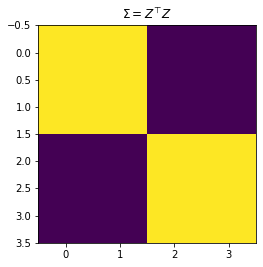

In [161]:
plt.imshow(Z_train.T@Z_train)
plt.title(r'$\Sigma = Z^\top Z$')

Text(0.5, 1.0, '$U A_1 U^\\top + U A_2 U^\\top$')

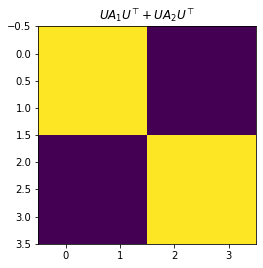

In [157]:
plt.imshow(U@r(A[0]).diag()@U.T + U@r(A[1]).diag()@U.T)
plt.title(r'$U A_1 U^\top + U A_2 U^\top$')

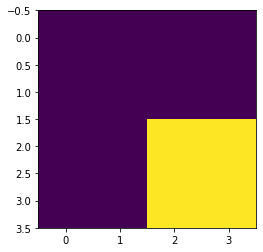

In [308]:
plt.imshow(U@r(A[1]).diag()@U.T)

In [158]:
print(r(A))

tensor([[0.0000, 0.0000, 0.0000, 9.9776],
        [5.1918, 0.0000, 4.7681, 0.0000]])


Text(0.5, 1.0, '$U^\\top U$')

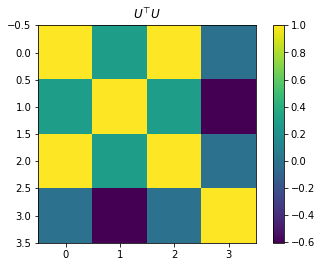

In [160]:
plt.imshow(U.T@U)
plt.colorbar()
plt.title(r'$U^\top U$')

In [285]:
torch.distributions.MultivariateNormal(torch.tensor([1.0,0,0,0]), torch.eye(4))

MultivariateNormal(loc: torch.Size([4]), covariance_matrix: torch.Size([4, 4]))

torch.Size([4, 3])
torch.Size([4, 6])
torch.Size([2, 6])


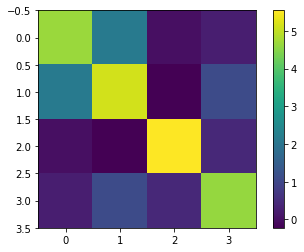

In [191]:
n_class = 2
n_features = 4
n_samples = 20
eps = 0.5
mu = 10.0
r = n_features
class1 = torch.distributions.MultivariateNormal(torch.tensor([0.0,0,0,0]), torch.tensor([1.0,0.5,1e-6,0.1]).diag())
class2 = torch.distributions.MultivariateNormal(torch.tensor([0.0,0,0,0]), torch.tensor([1e-6,0.1,1.0,0.5]).diag())
Z_train = torch.stack([class1.sample() for i in range(10)] + 
                       [class2.sample() for i in range(10)])
Z_train = F.normalize(Z_train)
Pi = torch.zeros(20, 2)
Pi[:10, 0] = 1.
Pi[10:, 1] = 1.

#Low rank approx
U1, S1, V1 = torch.linalg.svd(Z_train[:10].T@Z_train[:10])
U2, S2, V2 = torch.linalg.svd(Z_train[10:].T@Z_train[10:])
plt.imshow(Z_train.T@Z_train)
plt.colorbar()
print(U1[:,:3].shape)
U = torch.cat((U1[:,:3], U2[:,:3]), dim=1)
Z = nn.Parameter(
    Z_train.clone(),
    requires_grad=True
    )
U = nn.Parameter(
    U,
    requires_grad=True
    )
A = nn.Parameter(
    torch.stack( (torch.tensor([S1[0],S1[1],S1[2],0,0,0]), torch.tensor([0,0,0,S2[0],S2[1], S2[2]]))),
    requires_grad=True
    )

print(U.shape)
print(A.shape)
import torch.optim as optim
optimizer = optim.SGD([A, U], lr=1e-3)
optimizer_z = optim.SGD([Z], lr=1e-3)

In [192]:
loss = var_reg_U(Z.T, Pi, A, U)
print(loss)
criterion_mcr2var = MCR2Variational(eps, mu)
criterion_mcr = MCR2(eps)
loss_obj, loss_R, loss_Rc, loss_reg_U = criterion_mcr2var(Z, Pi, A, U)
true_obj, true_R, true_Rc = criterion_mcr(Z, Pi)

print(loss_R, loss_Rc)
print(true_R, true_Rc)

tensor(1.0966e-10, grad_fn=<DivBackward0>)
tensor(2.1380, grad_fn=<MulBackward0>) tensor(1.7090, grad_fn=<DivBackward0>)
2.1379783153533936 1.7090067863464355


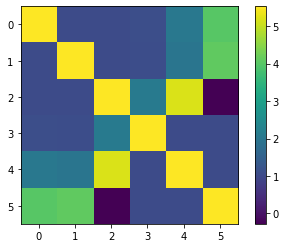

In [193]:
U_copy = U.clone().detach().numpy()
plt.imshow(U_copy.T@U_copy)
plt.colorbar(fig)

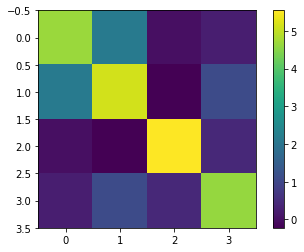

In [194]:
fig = plt.imshow(Z_train.T@Z_train)
plt.colorbar(fig)

In [ ]:
loss_dict = {'E':[], 'C':[], 'M':[]}
true_dict = {'E':[], 'C':[]}
Z_n = F.normalize(Z)
loss_obj, loss_R, loss_Rc, loss_reg_U = criterion_mcr2var(Z_n, Pi, A, U)
for epoch in range(30000):
    if epoch % 300 == 0:
            true_obj, true_R, true_Rc = criterion_mcr(Z, Pi)
            print(epoch, - loss_obj.item(), loss_R.item(), loss_Rc.item(), loss_reg_U.item())
            print(epoch, - true_obj.item(), true_R, true_Rc)
    if epoch%100 == 0:
        true_obj, true_R, true_Rc = criterion_mcr(Z, Pi)
        loss_dict['E'].append(loss_R.item())
        loss_dict['C'].append(loss_Rc.item())
        loss_dict['M'].append(loss_reg_U.item())
        true_dict['E'].append(true_R)
        true_dict['C'].append(true_Rc)
        
        
    for step in range(1):
        optimizer_z.zero_grad()
        Z_n = F.normalize(Z)
        loss_obj, loss_R, loss_Rc, loss_reg_U = criterion_mcr2var(Z_n, Pi, A, U)
        loss_obj.backward()
        optimizer_z.step()
    for step in range(20):
        optimizer.zero_grad()
        Z_n = F.normalize(Z)
        loss_obj, loss_R, loss_Rc, loss_reg_U = criterion_mcr2var(Z_n, Pi, A, U)
        loss_obj.backward()
        optimizer.step()

0 0.42897558212280273 2.1379785537719727 1.70900297164917 1.0879218637072086e-09
0 0.428971529006958 2.1379783153533936 1.7090067863464355
300 0.439704567193985 2.1386220455169678 1.696549892425537 0.002367597771808505
300 0.4372469186782837 2.138622999191284 1.7013760805130005
600 0.4481699466705322 2.1391422748565674 1.6885137557983398 0.0024585574865341187
600 0.44563138484954834 2.1391429901123047 1.6935116052627563
900 0.4565921127796173 2.1395959854125977 1.680450439453125 0.0025534252636134624
900 0.4539681673049927 2.1395976543426514 1.6856294870376587
1200 0.4649371802806854 2.1399946212768555 1.6724046468734741 0.0026527815498411655
1200 0.4622220993041992 2.1399967670440674 1.6777746677398682
1500 0.47316765785217285 2.140347957611084 1.6644253730773926 0.0027549315709620714
1500 0.47035646438598633 2.140350341796875 1.6699938774108887
1800 0.48124122619628906 2.140662670135498 1.6565611362457275 0.002860298380255699
1800 0.4783306121826172 2.1406655311584473 1.6623349189758

Text(0.5, 1.0, '$Z_0 Z_0^\\top$')

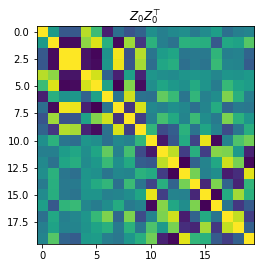

In [185]:
plt.imshow(Z_train@Z_train.T)
plt.title(r'$Z_0 Z_0^\top$')

Text(0.5, 1.0, '$Z^* Z^{*\\top}$')

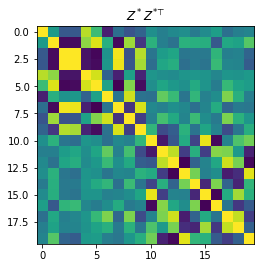

In [186]:
Z = Z.detach()
plt.imshow(Z@Z.T)
plt.title(r'$Z^* Z^{*\top}$')

In [187]:
Z = nn.Parameter(
    Z_train.clone(),
    requires_grad=True
    )
optimizer_z = optim.SGD([Z], lr=1e-3)
criterion_mcr2 = MCR2(eps)
mcr_dict = {'E':[], 'C':[]}
Z_n = F.normalize(Z)
loss_obj, loss_R, loss_Rc = criterion_mcr2(Z_n, Pi)
for epoch in range(30000):
    if epoch % 300 == 0:
            print(epoch, - loss_obj.item(), loss_R, loss_Rc)
    if epoch%100 == 0:
        mcr_dict['E'].append(loss_R)
        mcr_dict['C'].append(loss_Rc)
        
    optimizer_z.zero_grad()
    Z_n = F.normalize(Z)
    loss_obj, loss_R, loss_Rc = criterion_mcr2(Z_n, Pi)
    loss_obj.backward()
    optimizer_z.step()

0 0.4361393451690674 2.1521859169006348 1.7160465717315674
300 0.44687962532043457 2.152693033218384 1.7058134078979492
600 0.4574768543243408 2.153106689453125 1.6956298351287842
900 0.46781980991363525 2.153440475463867 1.685620665550232
1200 0.477832555770874 2.1537091732025146 1.6758766174316406
1500 0.4874424934387207 2.153927803039551 1.66648530960083
1800 0.49658286571502686 2.154109477996826 1.6575266122817993
2100 0.5051970481872559 2.154266834259033 1.6490697860717773
2400 0.5132405757904053 2.1544110774993896 1.6411705017089844
2700 0.5206817388534546 2.154550552368164 1.6338688135147095
3000 0.5275046825408936 2.154693126678467 1.6271884441375732
3300 0.5337071418762207 2.154844045639038 1.6211369037628174
3600 0.5392998456954956 2.1550073623657227 1.615707516670227
3900 0.5443053245544434 2.1551856994628906 1.6108803749084473
4200 0.5487546920776367 2.1553802490234375 1.6066255569458008
4500 0.5526852607727051 2.1555914878845215 1.6029062271118164
4800 0.5561387538909912 2

KeyboardInterrupt: 

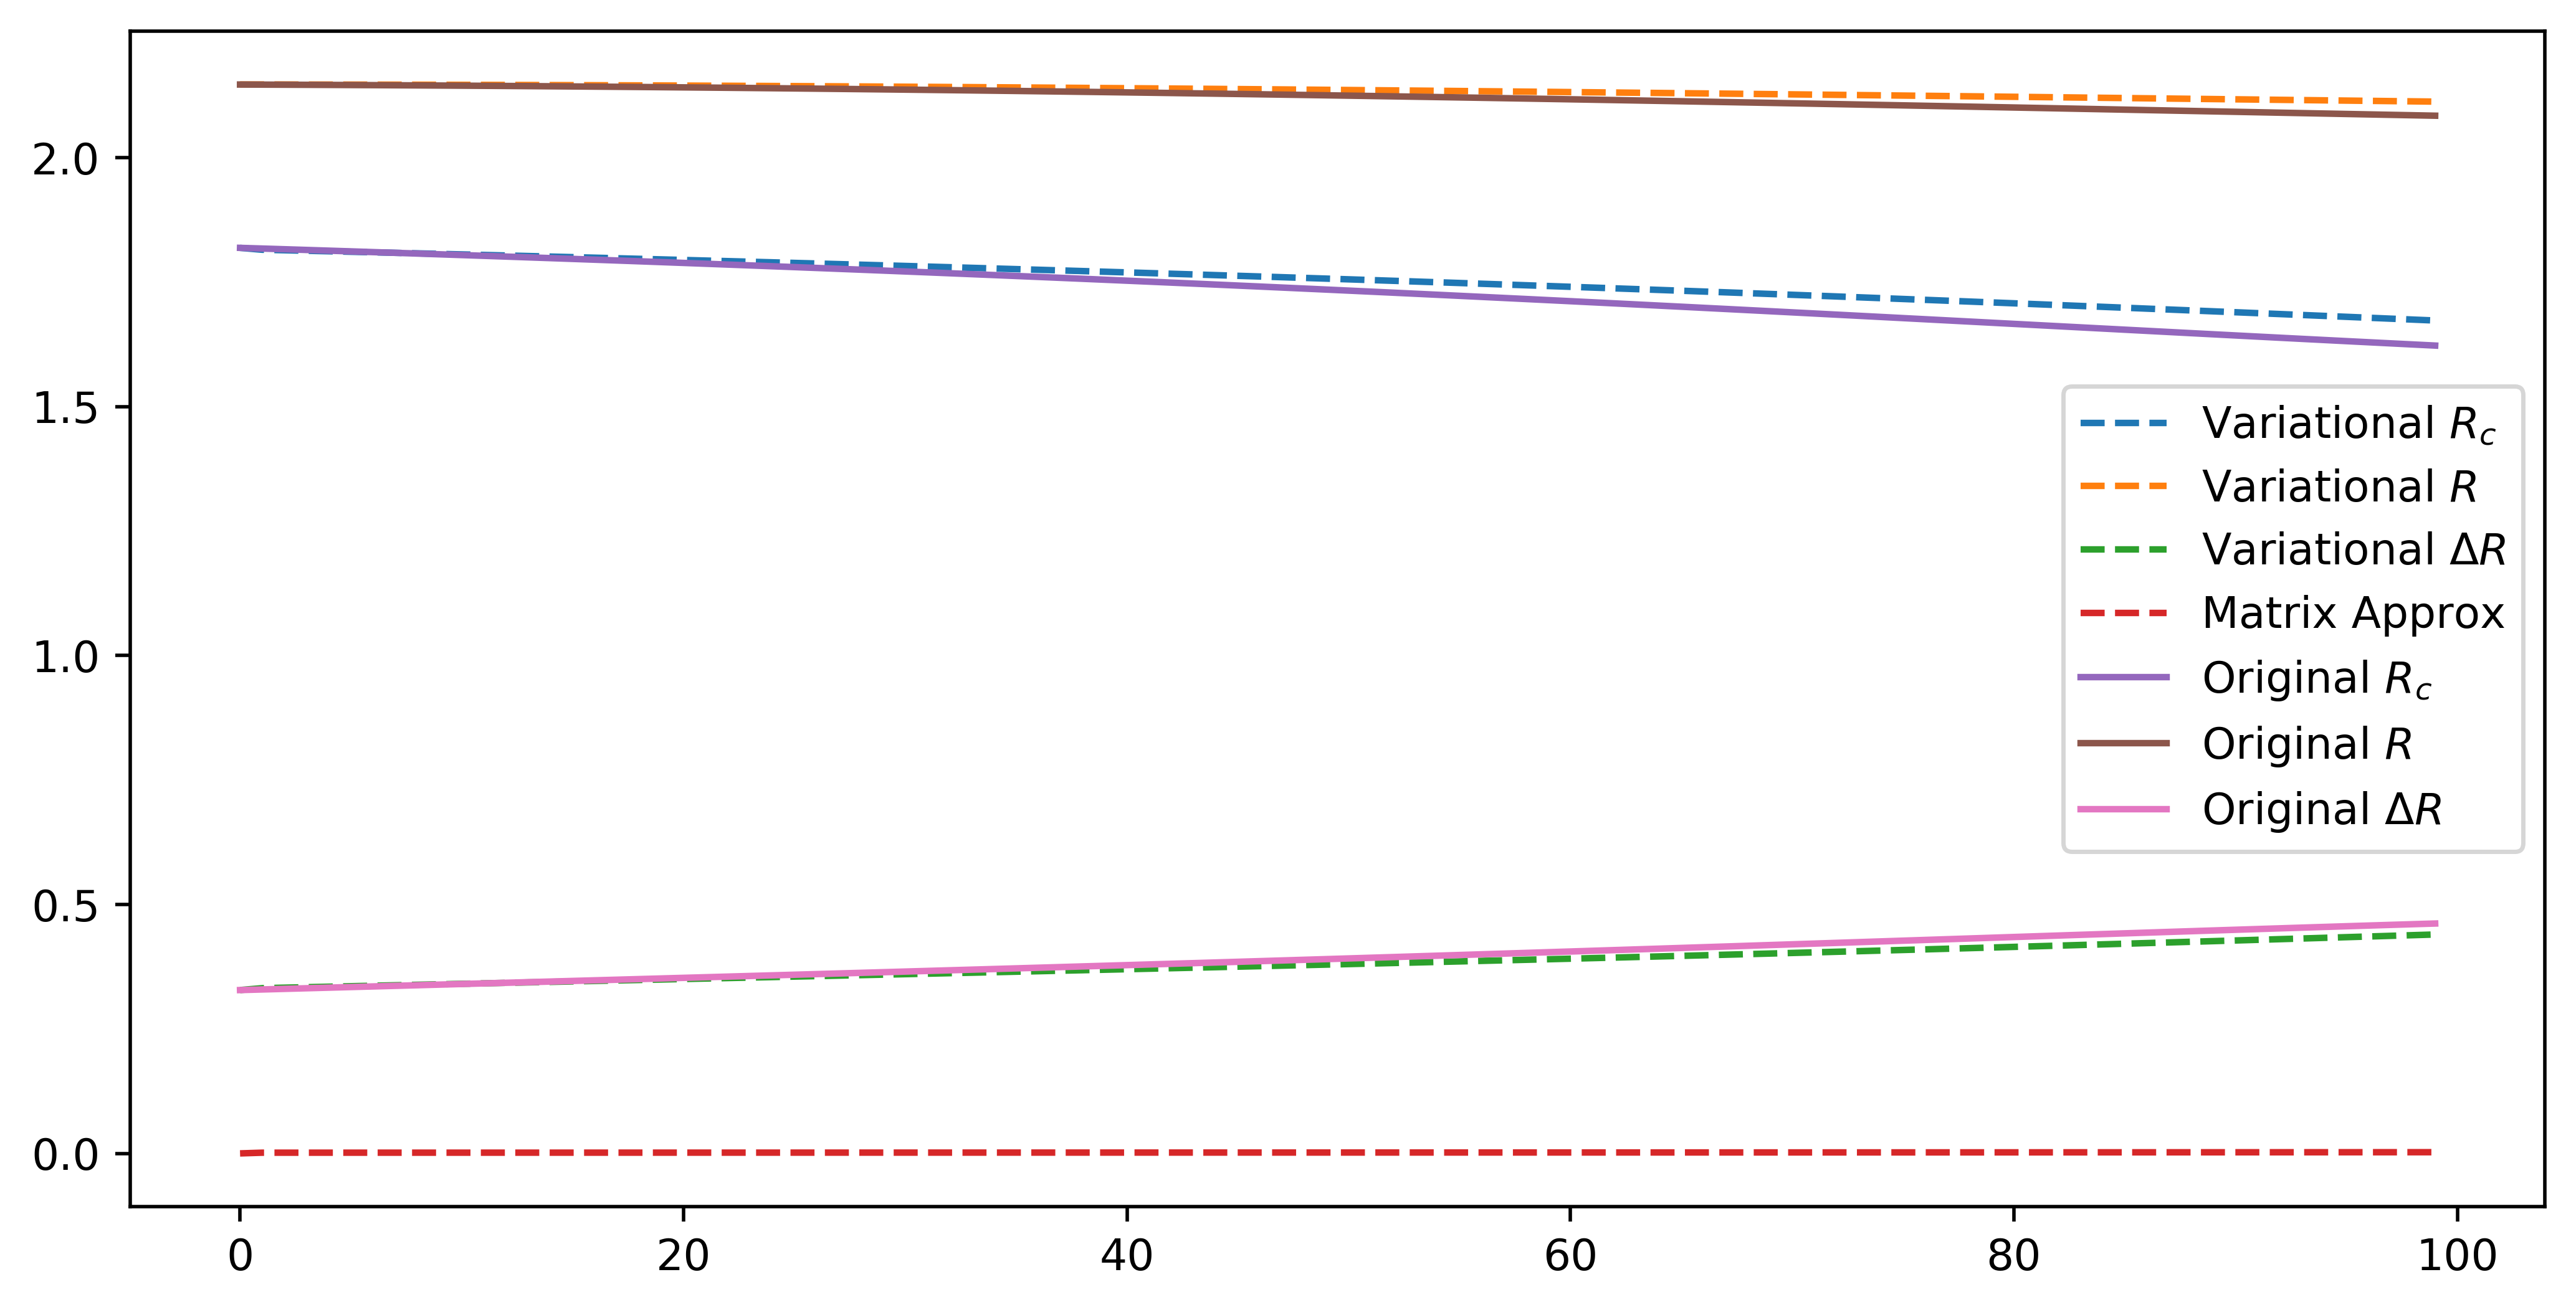

In [177]:
fig = plt.figure(figsize=(10,5), dpi=500)
plt.plot(loss_dict['C'], linestyle='--', label=r'Variational $R_c$')
plt.plot(loss_dict['E'], linestyle='--',label=r'Variational $R$')
plt.plot(np.array(loss_dict['E']) - np.array(loss_dict['C']), linestyle='--', label=r'Variational $\Delta R$')
plt.plot(loss_dict['M'], linestyle='--', label='Matrix Approx')
plt.plot(mcr_dict['C'], label=r'Original $R_c$')
plt.plot(mcr_dict['E'], label=r'Original $R$')
plt.plot(np.array(mcr_dict['E']) - np.array(mcr_dict['C']), label=r'Original $\Delta R$')

plt.legend()

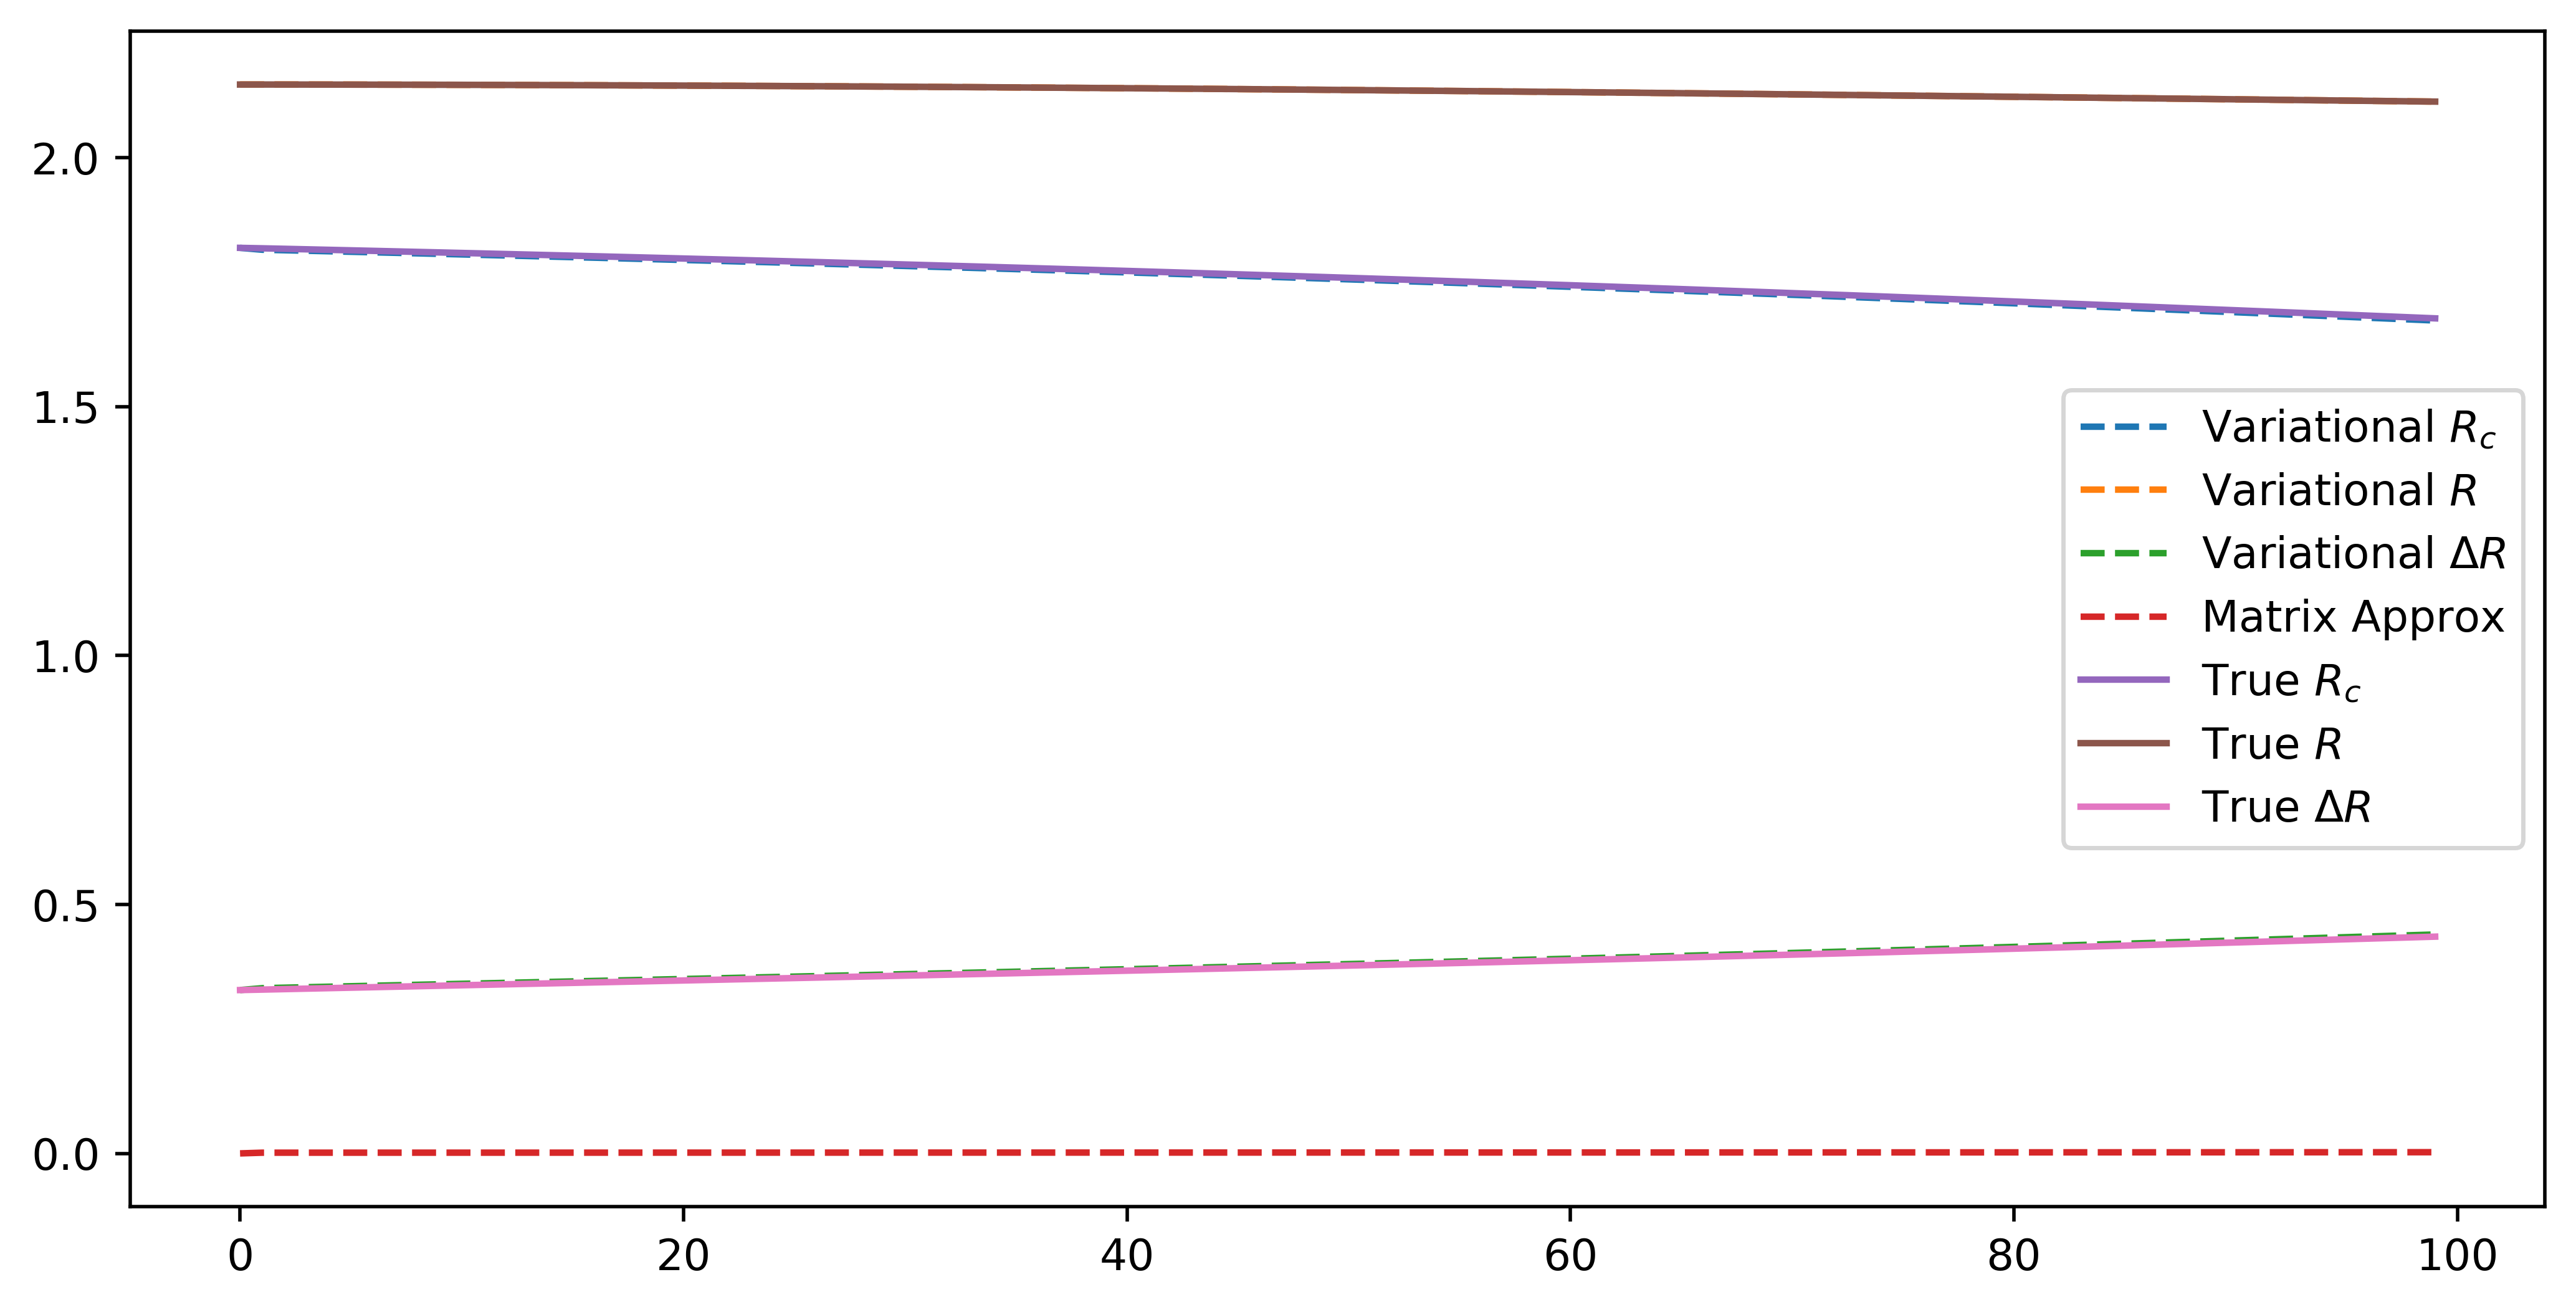

In [179]:
fig = plt.figure(figsize=(10,5), dpi=500)
plt.plot(loss_dict['C'], linestyle='--', label=r'Variational $R_c$')
plt.plot(loss_dict['E'], linestyle='--',label=r'Variational $R$')
plt.plot(np.array(loss_dict['E']) - np.array(loss_dict['C']), linestyle='--', label=r'Variational $\Delta R$')
plt.plot(loss_dict['M'], linestyle='--', label='Matrix Approx')
plt.plot(true_dict['C'], label=r'True $R_c$')
plt.plot(true_dict['E'], label=r'True $R$')
plt.plot(np.array(true_dict['E']) - np.array(true_dict['C']), label=r'True $\Delta R$')

plt.legend()